In [3]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import sqlite3
import random
import os
from calendar import monthrange

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

# Constants
START_DATE = datetime(2024, 1, 1)
END_DATE = datetime(2024, 12, 31)
SHIFTS = ['Morning', 'Afternoon', 'Night']
MACHINES = ['Filler_01', 'Packer_01', 'Labeler_01', 'Mixer_01', 'Capper_01']
EMPLOYEES = [f'EMP{str(i).zfill(3)}' for i in range(1, 31)]
LOCATIONS = ['Line_A', 'Line_B', 'Line_C']

def generate_date_range():
    total_days = (END_DATE - START_DATE).days + 1
    return [START_DATE + timedelta(days=x) for x in range(total_days)]

def get_monthly_downtime_days(year):
    downtime_days = {}
    for month in range(1, 13):
        _, days_in_month = monthrange(year, month)
        available_days = [datetime(year, month, day) for day in range(1, days_in_month + 1)]
        downtime_days[month] = random.sample(available_days, 4)  # 4 downtime days per month
    return downtime_days

def create_database_schema():
    conn = sqlite3.connect('syskron_production.db')
    cursor = conn.cursor()
    
    cursor.execute('''
        CREATE TABLE IF NOT EXISTS machines (
            machine_id INTEGER PRIMARY KEY,
            machine_name TEXT NOT NULL,
            location TEXT NOT NULL,
            installation_date DATE,
            max_capacity_per_hour INTEGER,
            maintenance_interval_days INTEGER,
            last_maintenance_date DATE,
            status TEXT
        )
    ''')
    
    cursor.execute('''
        CREATE TABLE IF NOT EXISTS shifts (
            shift_id INTEGER PRIMARY KEY,
            shift_name TEXT NOT NULL,
            start_time TEXT,
            end_time TEXT,
            supervisor_id TEXT,
            target_output INTEGER,
            shift_type TEXT,
            active BOOLEAN
        )
    ''')
    
    cursor.execute('''
        CREATE TABLE IF NOT EXISTS employees (
            employee_id TEXT PRIMARY KEY,
            first_name TEXT NOT NULL,
            last_name TEXT NOT NULL,
            hire_date DATE,
            shift_preference TEXT,
            skill_level TEXT,
            hourly_rate REAL,
            certification TEXT
        )
    ''')
    
    cursor.execute('''
        CREATE TABLE IF NOT EXISTS production_logs (
            production_id INTEGER PRIMARY KEY AUTOINCREMENT,
            date DATE,
            shift_id INTEGER,
            machine_id INTEGER,
            good_units INTEGER,
            scrap_units INTEGER,
            downtime_minutes INTEGER,
            FOREIGN KEY (shift_id) REFERENCES shifts(shift_id),
            FOREIGN KEY (machine_id) REFERENCES machines(machine_id)
        )
    ''')
    
    cursor.execute('''
        CREATE TABLE IF NOT EXISTS employee_shifts (
            assignment_id INTEGER PRIMARY KEY AUTOINCREMENT,
            date DATE,
            shift_id INTEGER,
            employee_id TEXT,
            hours_worked REAL,
            overtime_hours REAL,
            attendance_status TEXT,
            FOREIGN KEY (shift_id) REFERENCES shifts(shift_id),
            FOREIGN KEY (employee_id) REFERENCES employees(employee_id)
        )
    ''')
    
    conn.commit()
    conn.close()

def create_machines_data():
    return pd.DataFrame({
        'machine_id': range(1, len(MACHINES) + 1),
        'machine_name': MACHINES,
        'location': [random.choice(LOCATIONS) for _ in MACHINES],
        'installation_date': [START_DATE - timedelta(days=random.randint(100, 1000)) for _ in MACHINES],
        'max_capacity_per_hour': [random.randint(800, 1200) for _ in MACHINES],
        'maintenance_interval_days': [random.randint(30, 90) for _ in MACHINES],
        'last_maintenance_date': [START_DATE - timedelta(days=random.randint(0, 30)) for _ in MACHINES],
        'status': ['Active' for _ in MACHINES]
    })

def create_shifts_data():
    return pd.DataFrame({
        'shift_id': range(1, len(SHIFTS) + 1),
        'shift_name': SHIFTS,
        'start_time': ['06:00', '14:00', '22:00'],
        'end_time': ['14:00', '22:00', '06:00'],
        'supervisor_id': [random.choice(EMPLOYEES[:5]) for _ in SHIFTS],
        'target_output': [random.randint(5000, 8000) for _ in SHIFTS],
        'shift_type': [random.choice(['Regular', 'Extended']) for _ in SHIFTS],
        'active': [True for _ in SHIFTS]
    })

def create_employees_data():
    return pd.DataFrame({
        'employee_id': EMPLOYEES,
        'first_name': [f'First_{i}' for i in range(1, 31)],
        'last_name': [f'Last_{i}' for i in range(1, 31)],
        'hire_date': [START_DATE - timedelta(days=random.randint(30, 1000)) for _ in EMPLOYEES],
        'shift_preference': [random.choice(SHIFTS) for _ in EMPLOYEES],
        'skill_level': [random.choice(['Junior', 'Senior', 'Expert']) for _ in EMPLOYEES],
        'hourly_rate': [round(random.uniform(15.0, 30.0), 2) for _ in EMPLOYEES],
        'certification': [random.choice(['Basic', 'Advanced', 'None']) for _ in EMPLOYEES]
    })

def create_production_logs(dates, machines_df, shifts_df):
    records = []
    downtime_days = get_monthly_downtime_days(2024)
    
    for date in dates:
        date_str = date.strftime('%Y-%m-%d')
        month = date.month
        is_full_downtime = date in downtime_days[month]
        
        for shift_id in shifts_df['shift_id']:
            for machine_id in machines_df['machine_id']:
                if is_full_downtime:
                    good_units = scrap_units = 0
                    downtime_minutes = 480  # Full 8-hour downtime
                else:
                    # Random partial downtime (10% chance per shift-machine combo)
                    is_partial_downtime = random.random() < 0.1
                    if is_partial_downtime:
                        good_units = scrap_units = 0
                        downtime_minutes = random.randint(240, 480)  # 4-8 hours
                    else:
                        max_capacity = machines_df.loc[machine_id-1, 'max_capacity_per_hour'] * 8
                        good_units = int(np.random.normal(max_capacity * 0.90, max_capacity * 0.03))
                        scrap_units = int(np.random.normal(max_capacity * 0.03, max_capacity * 0.01))
                        downtime_minutes = random.randint(0, 24)  # Minimal downtime
                    
                records.append({
                    'date': date_str,
                    'shift_id': shift_id,
                    'machine_id': machine_id,
                    'good_units': max(0, good_units),
                    'scrap_units': max(0, scrap_units),
                    'downtime_minutes': min(downtime_minutes, 480)
                })
    return pd.DataFrame(records)

def create_employee_shifts(dates, employees_df, shifts_df):
    records = []
    downtime_days = get_monthly_downtime_days(2024)
    
    for date in dates:
        date_str = date.strftime('%Y-%m-%d')
        month = date.month
        is_full_downtime = date in downtime_days[month]
        
        available_employees = employees_df['employee_id'].tolist()
        random.shuffle(available_employees)
        
        for shift_id in shifts_df['shift_id']:
            if is_full_downtime:
                continue  # No employees assigned on full downtime days
            # Random shift off (10% chance)
            is_shift_off = random.random() < 0.1
            if is_shift_off:
                continue
            
            num_employees = random.randint(5, 8)
            shift_employees = available_employees[:num_employees]
            available_employees = available_employees[num_employees:]
            
            for emp_id in shift_employees:
                hours_worked = random.uniform(7.5, 8.5)
                overtime = max(0, hours_worked - 8.0)
                records.append({
                    'date': date_str,
                    'shift_id': shift_id,
                    'employee_id': emp_id,
                    'hours_worked': round(hours_worked, 2),
                    'overtime_hours': round(overtime, 2),
                    'attendance_status': random.choice(['Present', 'Late', 'Absent'])
                })
    return pd.DataFrame(records)

def export_to_sqlite(dfs):
    conn = sqlite3.connect('syskron_production.db')
    for table_name, df in dfs.items():
        df.to_sql(table_name, conn, if_exists='replace', index=False)
    conn.close()

# def main():
#     create_database_schema()
#     dates = generate_date_range()
#     machines_df = create_machines_data()
#     shifts_df = create_shifts_data()
#     employees_df = create_employees_data()
#     production_df = create_production_logs(dates, machines_df, shifts_df)
#     employee_shifts_df = create_employee_shifts(dates, employees_df, shifts_df)
    
#     tables = {
#         'machines': machines_df,
#         'shifts': shifts_df,
#         'employees': employees_df,
#         'production_logs': production_df,
#         'employee_shifts': employee_shifts_df
#     }
    
#     export_to_sqlite(tables)
    
#     print("Database creation complete!")
#     print(f"Generated {len(dates)} days of data")
#     print(f"Machines: {len(machines_df)} records")
#     print(f"Shifts: {len(shifts_df)} records")
#     print(f"Employees: {len(employees_df)} records")
#     print(f"Production logs: {len(production_df)} records")
#     print(f"Employee shifts: {len(employee_shifts_df)} records")

# if __name__ == "__main__":
#     main()

In [4]:
create_database_schema()

In [5]:
dates = generate_date_range()
machines_df = create_machines_data()
shifts_df = create_shifts_data()
employees_df = create_employees_data()
production_df = create_production_logs(dates, machines_df, shifts_df)
employee_shifts_df = create_employee_shifts(dates, employees_df, shifts_df)

In [6]:
machines_df.head()

,machine_id,machine_name,location,installation_date,max_capacity_per_hour,maintenance_interval_days,last_maintenance_date,status
0,1,Filler_01,Line_C,2023-01-16,1146,57,2023-12-25,Active
1,2,Packer_01,Line_A,2023-02-07,1179,32,2023-12-16,Active
2,3,Labeler_01,Line_A,2023-05-04,1079,31,2023-12-13,Active
3,4,Mixer_01,Line_C,2021-08-30,844,35,2024-01-01,Active
4,5,Capper_01,Line_B,2023-06-11,1102,43,2023-12-15,Active


In [7]:
shifts_df.head()

,shift_id,shift_name,start_time,end_time,supervisor_id,target_output,shift_type,active
0,1,Morning,06:00,14:00,EMP002,5902,Extended,True
1,2,Afternoon,14:00,22:00,EMP005,6839,Regular,True
2,3,Night,22:00,06:00,EMP004,7413,Regular,True


In [8]:
employees_df.head()

,employee_id,first_name,last_name,hire_date,shift_preference,skill_level,hourly_rate,certification
0,EMP001,First_1,Last_1,2021-12-18,Night,Junior,21.88,Advanced
1,EMP002,First_2,Last_2,2022-09-26,Afternoon,Expert,18.97,Basic
2,EMP003,First_3,Last_3,2022-12-19,Night,Expert,18.70,Advanced
3,EMP004,First_4,Last_4,2023-02-21,Morning,Junior,23.42,Basic
4,EMP005,First_5,Last_5,2023-06-26,Night,Junior,18.94,None


In [9]:
production_df.head(20)

,date,shift_id,machine_id,good_units,scrap_units,downtime_minutes
0,2024-01-01,1,1,0,0,401
1,2024-01-01,1,2,0,0,257
2,2024-01-01,1,3,7897,247,10
3,2024-01-01,1,4,0,0,300
4,2024-01-01,1,5,8105,398,15
5,2024-01-01,2,1,8186,253,4
6,2024-01-01,2,2,8935,355,18
7,2024-01-01,2,3,7647,305,7
8,2024-01-01,2,4,5982,171,13
9,2024-01-01,2,5,7998,95,3


In [10]:
employee_shifts_df.head()

,date,shift_id,employee_id,hours_worked,overtime_hours,attendance_status
0,2024-01-01,1,EMP026,8.25,0.25,Absent
1,2024-01-01,1,EMP002,7.90,0.00,Late
2,2024-01-01,1,EMP030,7.51,0.00,Present
3,2024-01-01,1,EMP025,8.32,0.32,Present
4,2024-01-01,1,EMP024,7.60,0.00,Absent


In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_monthly_downtime(df, start_month, end_month):
    """
    Plots monthly downtime trends for the given DataFrame within the specified date range.
    
    Parameters:
    df (pd.DataFrame): The production logs DataFrame with 'date' and 'downtime_minutes'.
    start_month (str): The start month in 'YYYY-MM' format.
    end_month (str): The end month in 'YYYY-MM' format.
    """
    # Ensure 'date' is in datetime format
    df = df.copy()  # Avoid modifying the original DataFrame
    df["date"] = pd.to_datetime(df["date"])
    
    # Extract month-year for grouping
    df["month"] = df["date"].dt.to_period("M")
    
    # Filter data within the given date range
    df_filtered = df[(df["month"] >= start_month) & (df["month"] <= end_month)]
    
    # Aggregate total downtime per month
    monthly_downtime = df_filtered.groupby("month")["downtime_minutes"].sum()

    # Plot the monthly downtime trend
    plt.figure(figsize=(8, 5))
    monthly_downtime.plot(kind="bar", color="orange", edgecolor="black")
    plt.xlabel("Month")
    plt.ylabel("Total Downtime (Minutes)")
    plt.title("Monthly Downtime Trend")
    plt.xticks(rotation=45)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    
    # Show the plot
    plt.show()


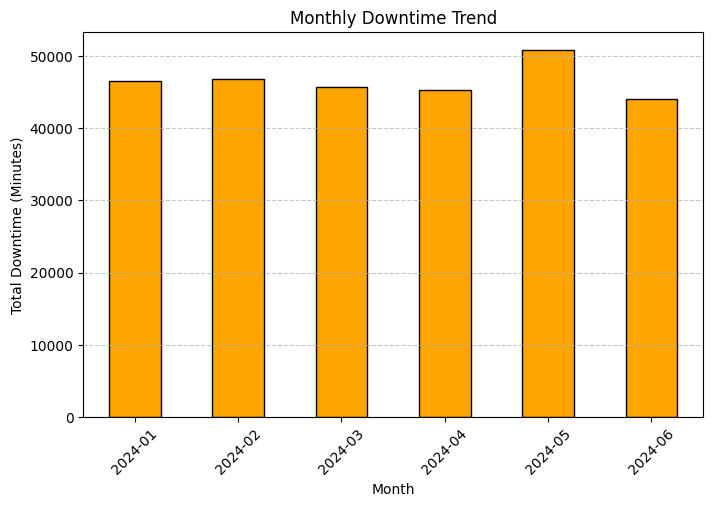

In [13]:
plot_monthly_downtime(production_df, "2024-01", "2024-06")


In [14]:
import pandas as pd

def get_off_days(df, target_month):
    """
    Finds the number of days and exact dates when production was off in a given month.

    Parameters:
    df (pd.DataFrame): The production logs DataFrame with 'date' and 'good_units' columns.
    target_month (str): The target month in 'YYYY-MM' format.

    Returns:
    tuple: (number of off days, list of dates when production was off)
    """
    # Ensure 'date' is in datetime format
    df = df.copy()
    df["date"] = pd.to_datetime(df["date"])
    
    # Extract month-year for filtering
    df["month"] = df["date"].dt.to_period("M")
    
    # Filter data for the given month
    df_filtered = df[df["month"] == target_month]
    
    # Group by date and sum good_units to find off days
    daily_production = df_filtered.groupby("date")["good_units"].sum()
    off_days = daily_production[daily_production == 0].index.tolist()

    return len(off_days), off_days


In [15]:
num_off_days, off_days_list = get_off_days(production_df, "2024-02")
print(f"Total off days: {num_off_days}, Off days: {off_days_list}")


Total off days: 4, Off days: [Timestamp('2024-02-03 00:00:00'), Timestamp('2024-02-16 00:00:00'), Timestamp('2024-02-24 00:00:00'), Timestamp('2024-02-27 00:00:00')]


In [16]:
import matplotlib.pyplot as plt

def plot_good_vs_scrap_units(df, target_month):
    """
    Plots a multi-bar chart of good units and scrap units for each date in the target month.

    Parameters:
    df (pd.DataFrame): The production logs DataFrame with 'date', 'good_units', and 'scrap_units' columns.
    target_month (str): The target month in 'YYYY-MM' format.
    """
    # Ensure 'date' is in datetime format
    df = df.copy()
    df["date"] = pd.to_datetime(df["date"])
    
    # Extract month-year for filtering
    df["month"] = df["date"].dt.to_period("M")
    
    # Filter data for the given month
    df_filtered = df[df["month"] == target_month]
    
    # Group by date to sum good units and scrap units
    daily_data = df_filtered.groupby("date")[["good_units", "scrap_units"]].sum()

    # Plot the multi-bar chart
    plt.figure(figsize=(10, 5))
    bar_width = 0.4
    x = range(len(daily_data))

    plt.bar(x, daily_data["good_units"], width=bar_width, label="Good Units", color="green", align="center")
    plt.bar(x, daily_data["scrap_units"], width=bar_width, label="Scrap Units", color="red", align="edge")

    # Formatting the plot
    plt.xlabel("Date")
    plt.ylabel("Units")
    plt.title(f"Good vs Scrap Units - {target_month}")
    plt.xticks(x, daily_data.index.strftime("%Y-%m-%d"), rotation=45)
    plt.legend()
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    
    # Show the plot
    plt.show()


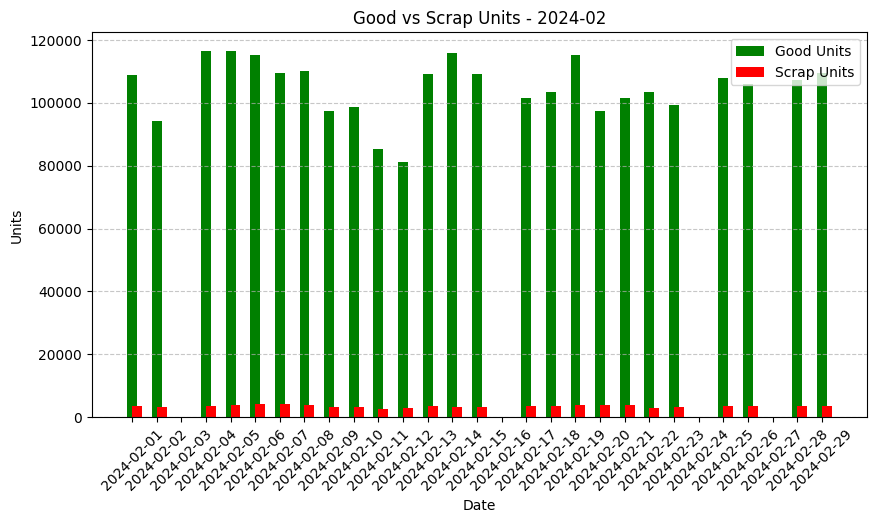

In [17]:
plot_good_vs_scrap_units(production_df, "2024-02")


In [18]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

def visualize_shift_operations(df, target_month):
    """
    Creates heatmap and stacked bar chart to show which shifts were operational for each day in the target month.
    
    Parameters:
    df (pd.DataFrame): Production logs DataFrame with 'date', 'shift_id', and 'good_units' columns.
    target_month (str): The target month in 'YYYY-MM' format.
    """
    # Convert 'date' column to datetime
    df = df.copy()
    df["date"] = pd.to_datetime(df["date"])

    # Extract year-month for filtering
    df["month"] = df["date"].dt.to_period("M")

    # Filter data for the given target month
    df_filtered = df[df["month"] == target_month]

    # Aggregate: Count how many machines were running per shift each day
    df_grouped = df_filtered.groupby(["date", "shift_id"])["good_units"].apply(lambda x: (x > 0).sum()).reset_index()
    
    # ---- Heatmap Plot ----
    heatmap_fig = px.imshow(
        df_grouped.pivot(index="date", columns="shift_id", values="good_units"),
        labels=dict(color="Machines Running"),
        title=f"Shift Operations Heatmap - {target_month}",
        color_continuous_scale="Blues"
    )
    
    heatmap_fig.update_layout(
        xaxis_title="Shift ID",
        yaxis_title="Date",
        xaxis_type="category",
        yaxis_type="category"
    )

    # ---- Stacked Bar Chart ----
    bar_fig = px.bar(
        df_grouped, x="date", y="good_units", color="shift_id",
        title=f"Operational Machines Per Shift - {target_month}",
        labels={"good_units": "Number of Machines Running", "date": "Date", "shift_id": "Shift"},
        barmode="stack"
    )

    # Show plots
    heatmap_fig.show()
    bar_fig.show()


In [19]:
visualize_shift_operations(production_df, "2024-01")


In [20]:
import sqlite3

# Connect to SQLite database (creates file if not exists)
conn = sqlite3.connect("syskron_production.db")
cursor = conn.cursor()




In [21]:
# Execute a query
cursor.execute("SELECT COUNT(DISTINCT pl.date) as production_off_days FROM production_logs pl WHERE pl.good_units = 0 AND pl.scrap_units = 0 AND pl.date LIKE '2024-02%'")

In [22]:

# cursor.execute("INSERT INTO users (name) VALUES (?)", ("Alice",))

# Commit changes and fetch results
conn.commit()
# cursor.execute("SELECT * FROM users")
# rows = cursor.fetchall()

# for row in rows:
#     print(row)

# # Close the connection
# conn.close()

In [23]:
# Execute a query
cursor.execute("SELECT COUNT(DISTINCT pl.date) as production_off_days FROM production_logs pl WHERE pl.good_units = 0 AND pl.scrap_units = 0 AND pl.date LIKE '2024-02%'")

In [24]:
rows = cursor.fetchall()

for row in rows:
    print(row)

(0,)
